In [2]:
# %pip install jupyter ipywidgets pandas seaborn scikit-learn torch shap phik scipy catboost xgboost optuna joblib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import scipy as sp

import phik

import optuna

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, \
                            make_scorer, log_loss


from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

## Const

In [5]:
SEED = 101

sns.set_palette("Accent")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## General data characteristics

In [6]:
df = pd.read_csv('../../DATA/Telco-Customer-Churn.csv')

In [7]:
df.head(10)
pd.set_option('display.max_columns', None)

In [8]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   str    
 1   gender            7032 non-null   str    
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   str    
 4   Dependents        7032 non-null   str    
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   str    
 7   MultipleLines     7032 non-null   str    
 8   InternetService   7032 non-null   str    
 9   OnlineSecurity    7032 non-null   str    
 10  OnlineBackup      7032 non-null   str    
 11  DeviceProtection  7032 non-null   str    
 12  TechSupport       7032 non-null   str    
 13  StreamingTV       7032 non-null   str    
 14  StreamingMovies   7032 non-null   str    
 15  Contract          7032 non-null   str    
 16  PaperlessBilling  7032 non-null   str    
 17  Paymen

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


'SeniorCitizen' - one-hot

In [10]:
df['Churn'].describe()

count     7032
unique       2
top         No
freq      5163
Name: Churn, dtype: object

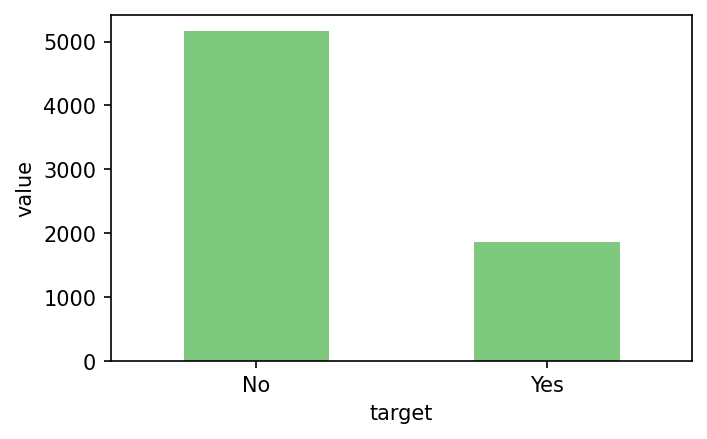

In [11]:
count_val = df['Churn'].value_counts()

plt.figure(figsize=(5,3), dpi=150)

ax = count_val.plot(
    kind='bar',
    x='Churn',
    xlabel='target',
    ylabel='value',
    rot=0,
)

plt.show()

In [12]:
df_dup = df.copy()

df_dup = df_dup.drop(['customerID', 'PhoneService'], axis=1)

In [13]:
print('Row duplicate:', df_dup.duplicated().sum())

df_dup = df_dup.drop_duplicates()

Row duplicate: 22


In [14]:
df_eda = df_dup.copy()

In [15]:
df_eda.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [16]:
def select_cat(df):
    categorial_df = df.select_dtypes(include='str')
    
    data = []
    
    for col in categorial_df.columns:
        data.append({
            'Feature': col,
            'Unique': ', '.join(df[col].unique()),
            'Amount': df[col].nunique()
        })
    
    return pd.DataFrame(data)

select_cat(df_eda)

,Feature,Unique,Amount
0,gender,"Female, Male",2
1,Partner,"Yes, No",2
2,Dependents,"No, Yes",2
3,MultipleLines,"No phone service, No, Yes",3
4,InternetService,"DSL, Fiber optic, No",3
5,OnlineSecurity,"No, Yes, No internet service",3
6,OnlineBackup,"Yes, No, No internet service",3
7,DeviceProtection,"No, Yes, No internet service",3
8,TechSupport,"No, Yes, No internet service",3
9,StreamingTV,"No, Yes, No internet service",3


In [17]:
df_eda.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7010.000000,7010.000000,7010.000000,7010.000000
mean,0.162767,32.520399,64.888666,2290.353388
std,0.369180,24.520441,30.064769,2266.820832
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.750000,408.312500
50%,0.000000,29.000000,70.400000,1403.875000
75%,0.000000,56.000000,89.900000,3807.837500
max,1.000000,72.000000,118.750000,8684.800000


In [18]:
def box_plot_out(df, cols= None, ax=None):
    
    # For axes check. [show() and close()].
    stand_still = True
    
    # We check whether the 'cols' parameters are passed to the func.
    if cols is None:
        data = df
    else:
        data = df[cols]
    
    # We check whether the 'axes' parameters are passed to the func.
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 8))
    else:
        stand_still = False
    
    sns.boxplot(      # Our plot.
        data=data,
        ax=ax
    )
    
    title = 'Range of feature meaning'
    if cols is not None:       # title for cols>1.
        title += f': {cols}'
    
    ax.set_title(title)
    ax.grid(True, axis='y')
    ax.tick_params(axis='x', rotation=90)
    
    # if we make only 1 graph.
    if stand_still:
        plt.show()
        plt.close()
    
    return ax

In [19]:
def del_bool_cols(df):
    #select data without {0,1} (bool), and only numeric samples.
    numeric_data = df.select_dtypes(include='number')
    
    return numeric_data.loc[:, ~numeric_data.isin([0, 1]).all()]

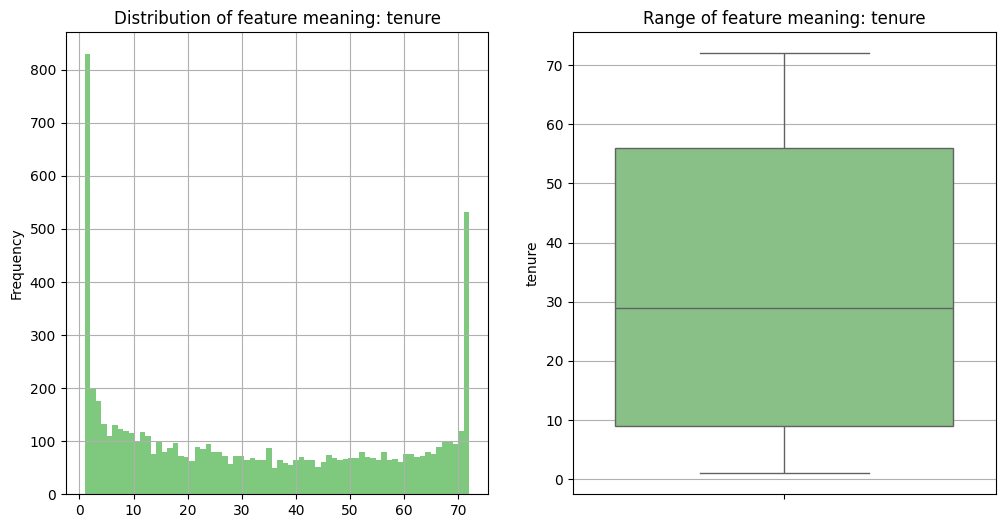

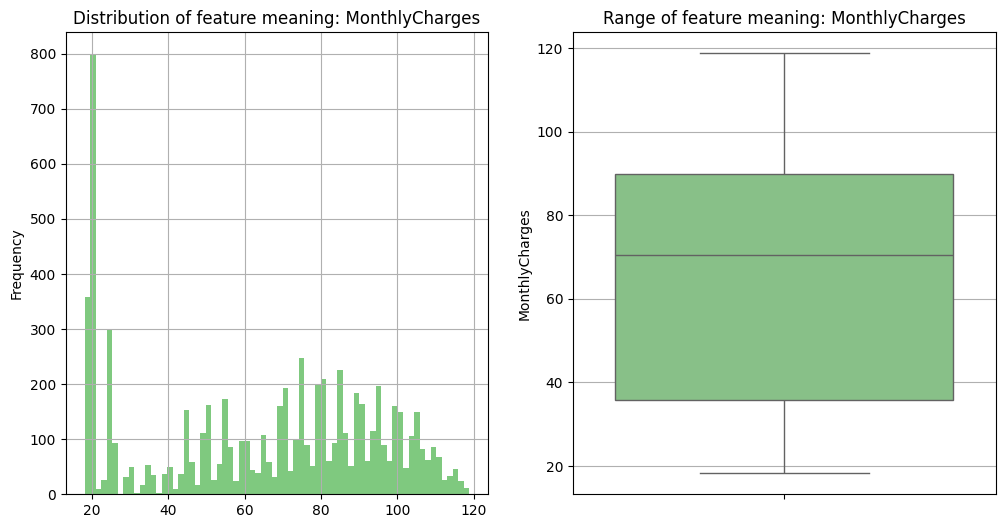

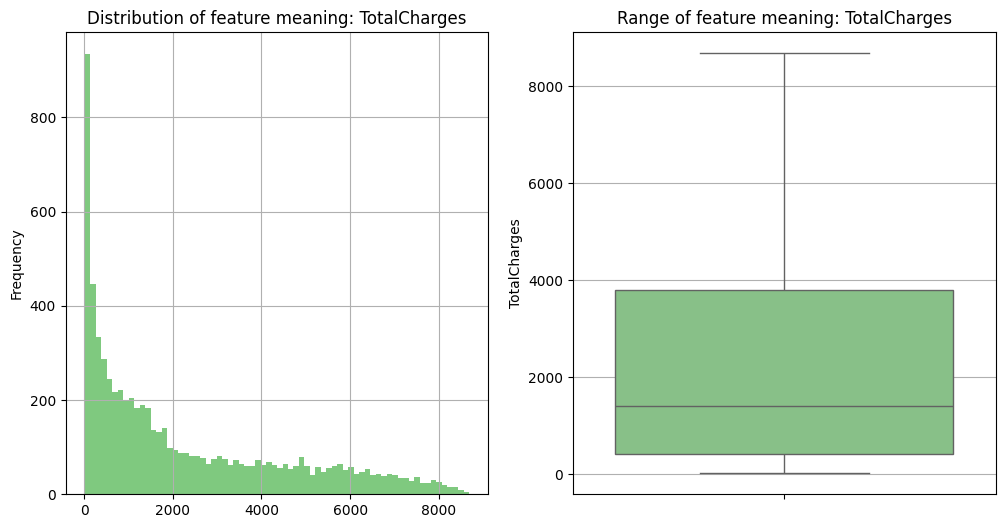

In [20]:
def emission_analysis(df):
    # Call func for del all not numeric variables.
    data = del_bool_cols(df)
    
    #For grid with hist and box plots.
    for col in data:
        _, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
        
        data[col].plot(     # hist plot.
            kind='hist',
            ax=axes[0],
            bins=70,
            grid=True
        )
        
        # Visual 
        axes[0].set_title(f'Distribution of feature meaning: {col}')
        
        # our box plot func.
        box_plot_out(data, col, axes[1])
        
        plt.show()
        plt.close()

# call func for df.
emission_analysis(df_eda)

In [21]:
def count_plot_cat(df):
    
    data = df.select_dtypes(include='object') # Choose only categorical samples.
    
    for col in data:
        plt.figure(figsize=(10, 4), dpi=150)
        
        ax = sns.countplot(
            data=data,
            x=col,
        )
        
        ax.set_title(f'Distribution of {col} meaning')
        
        plt.show()
        plt.close()

C:\Users\toperok\AppData\Local\Temp\ipykernel_21716\403707158.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  data = df.select_dtypes(include='object') # Choose only categorical samples.


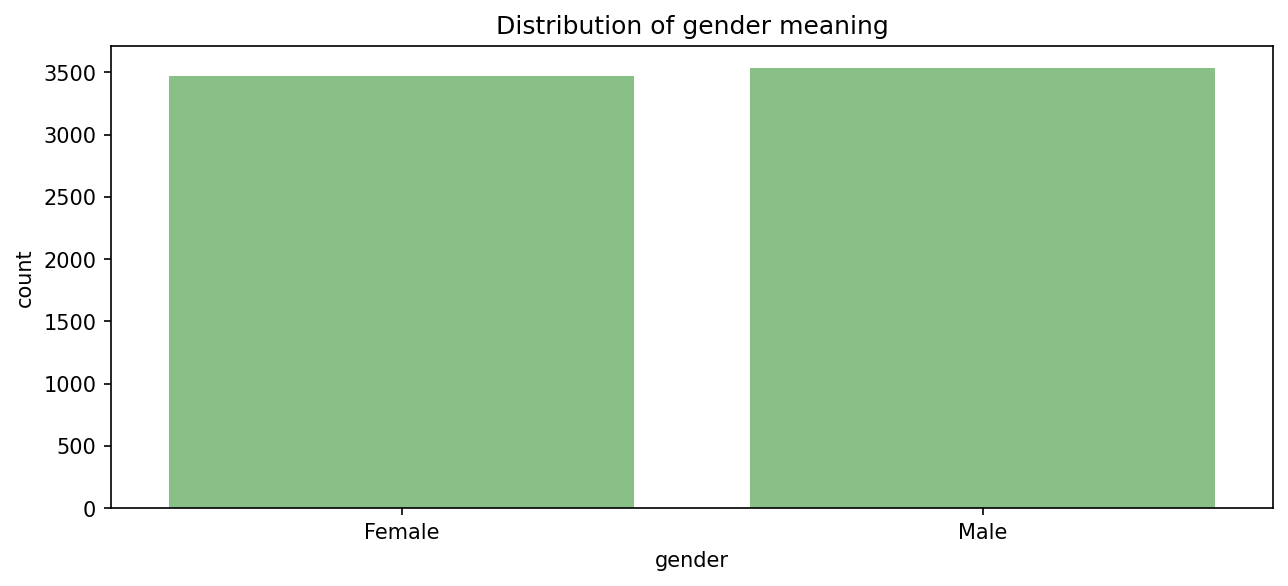

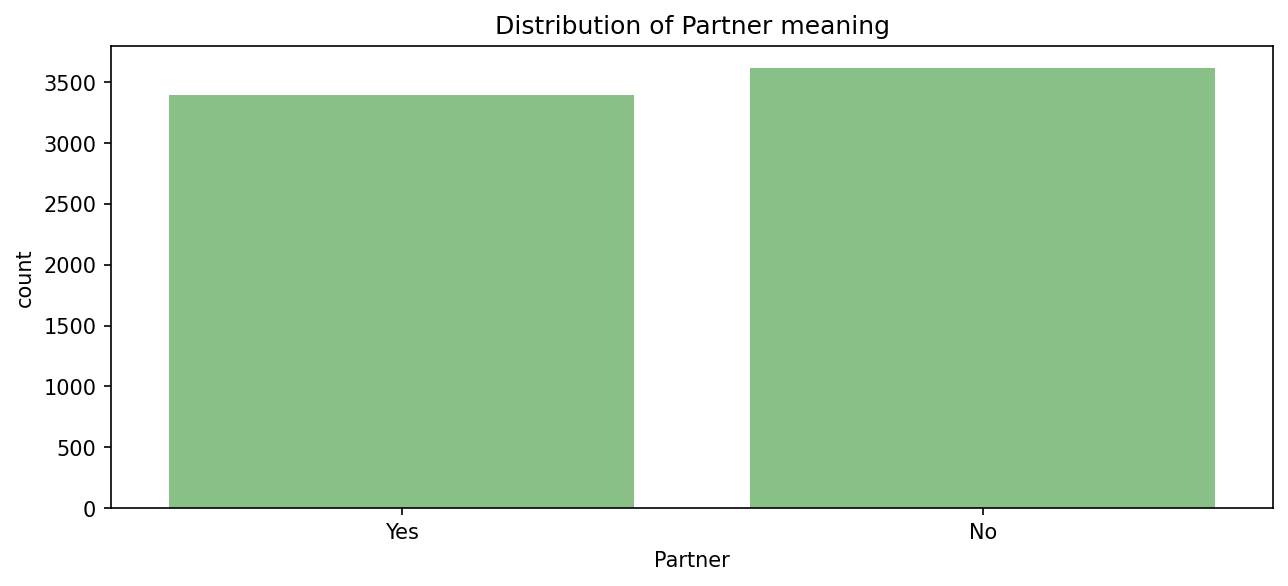

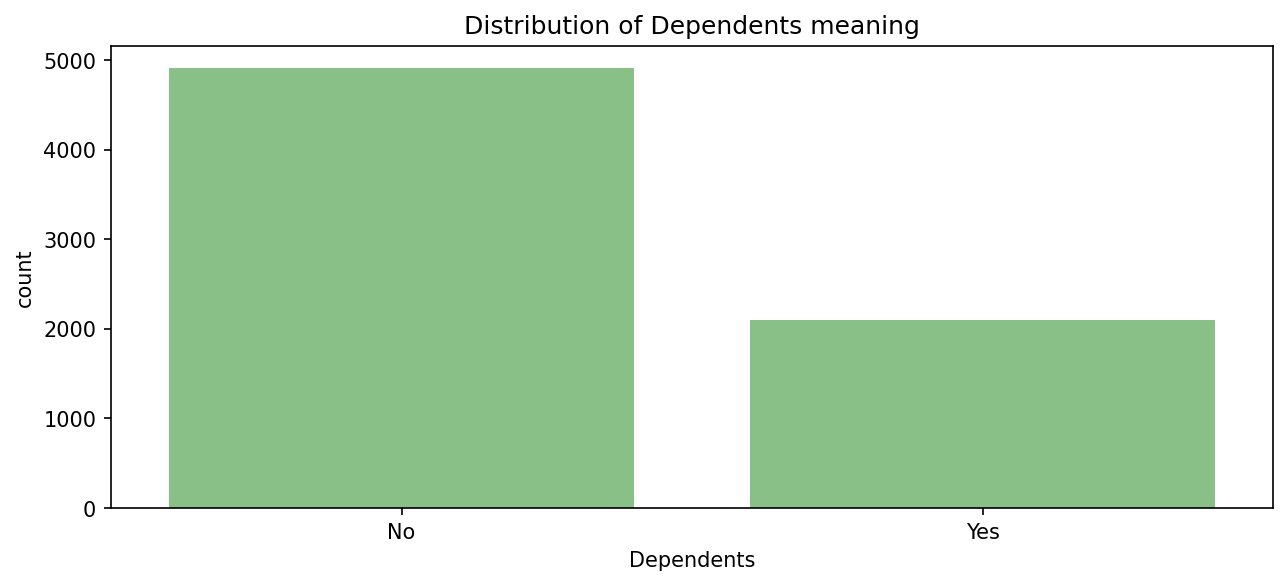

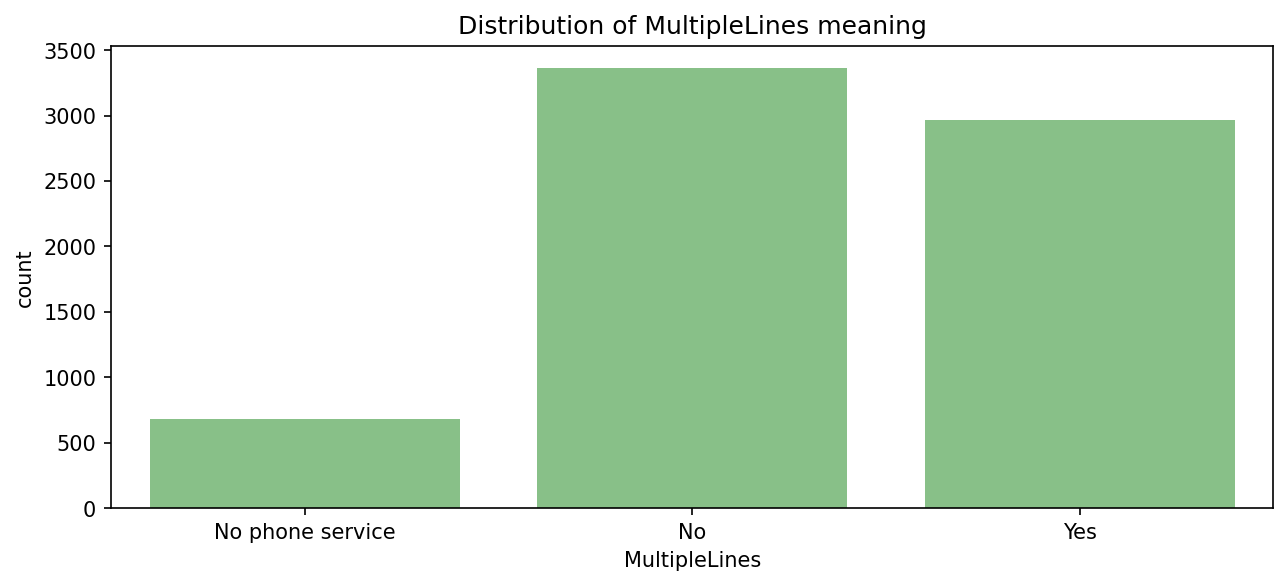

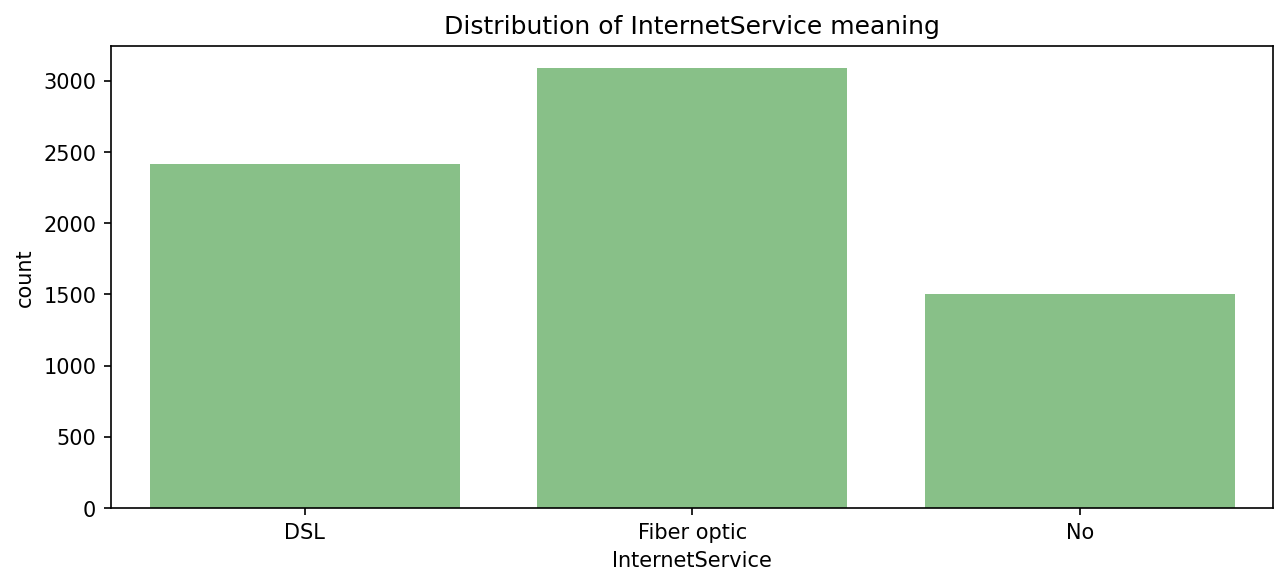

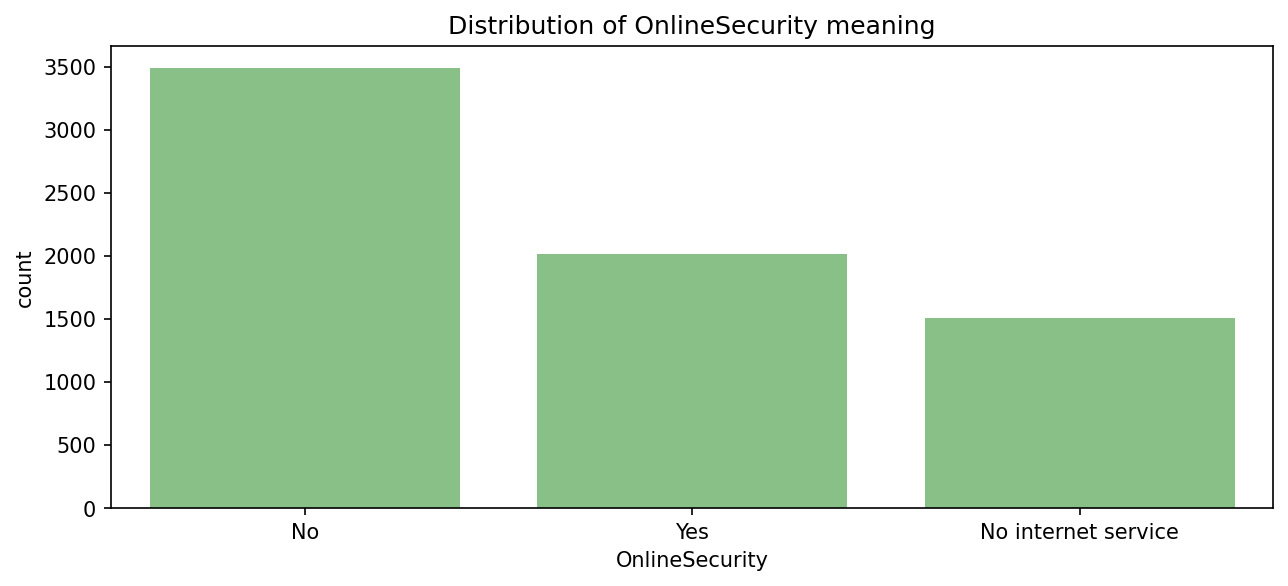

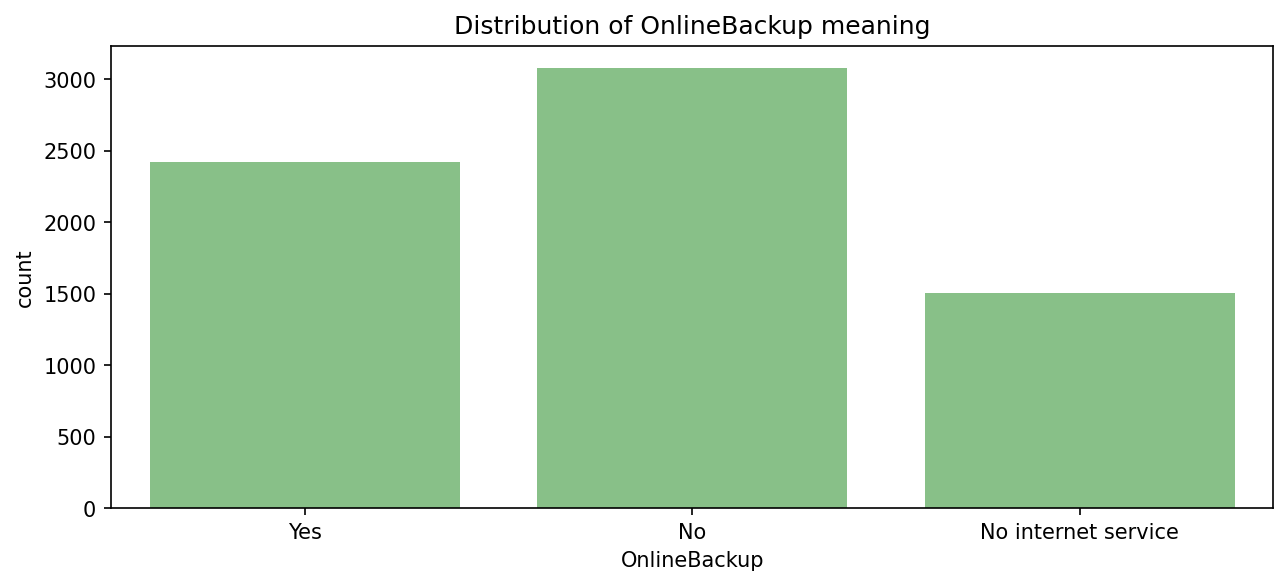

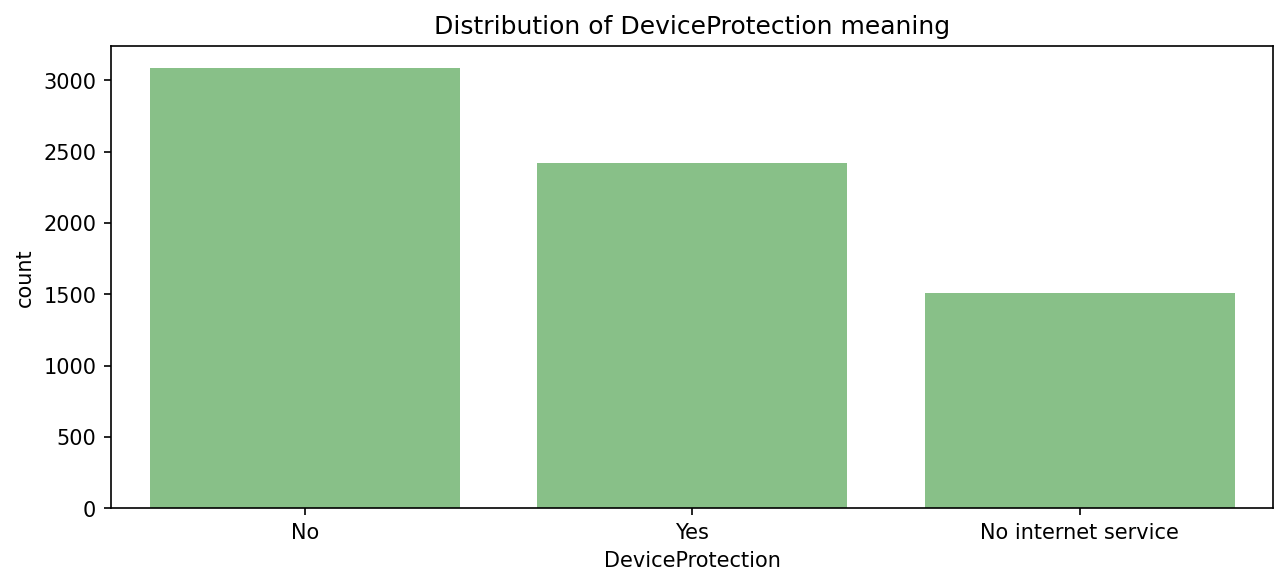

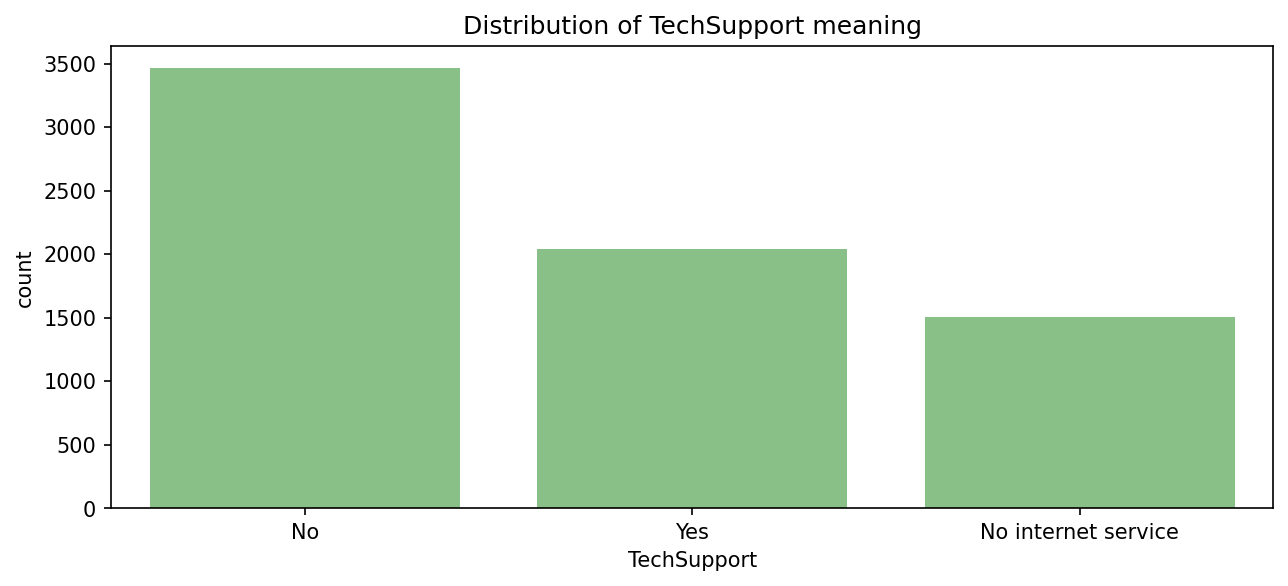

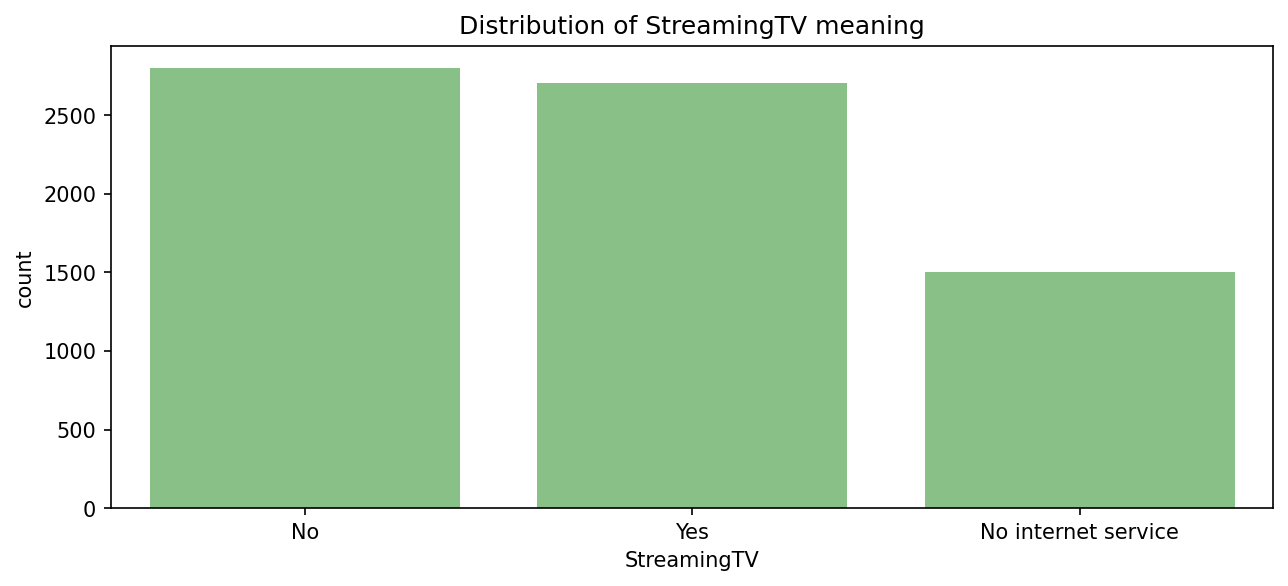

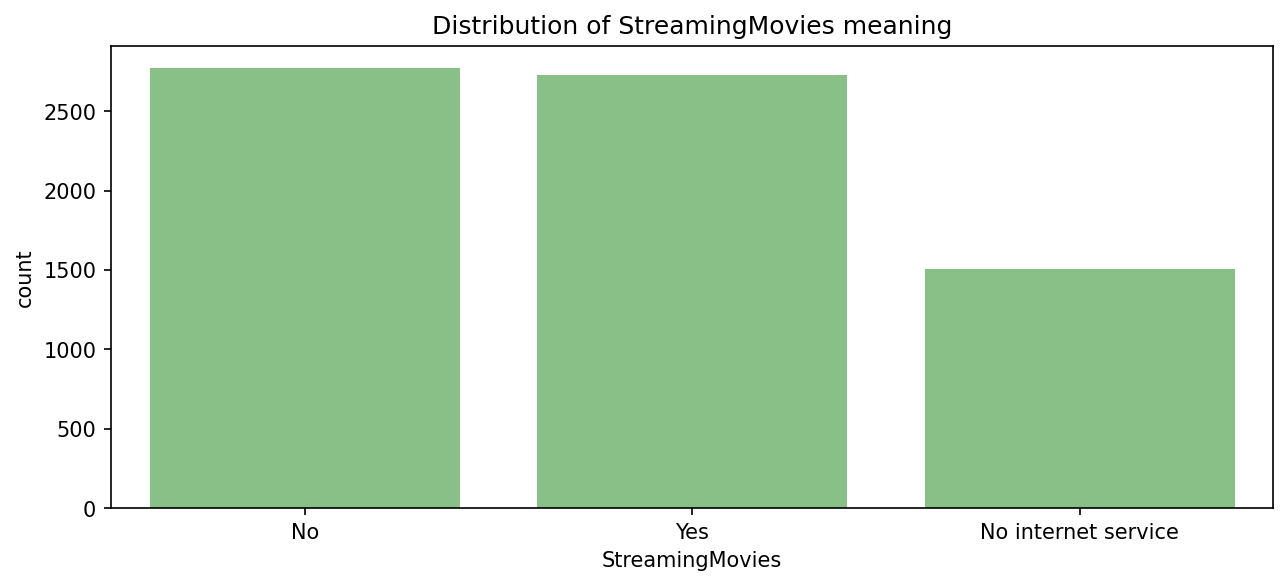

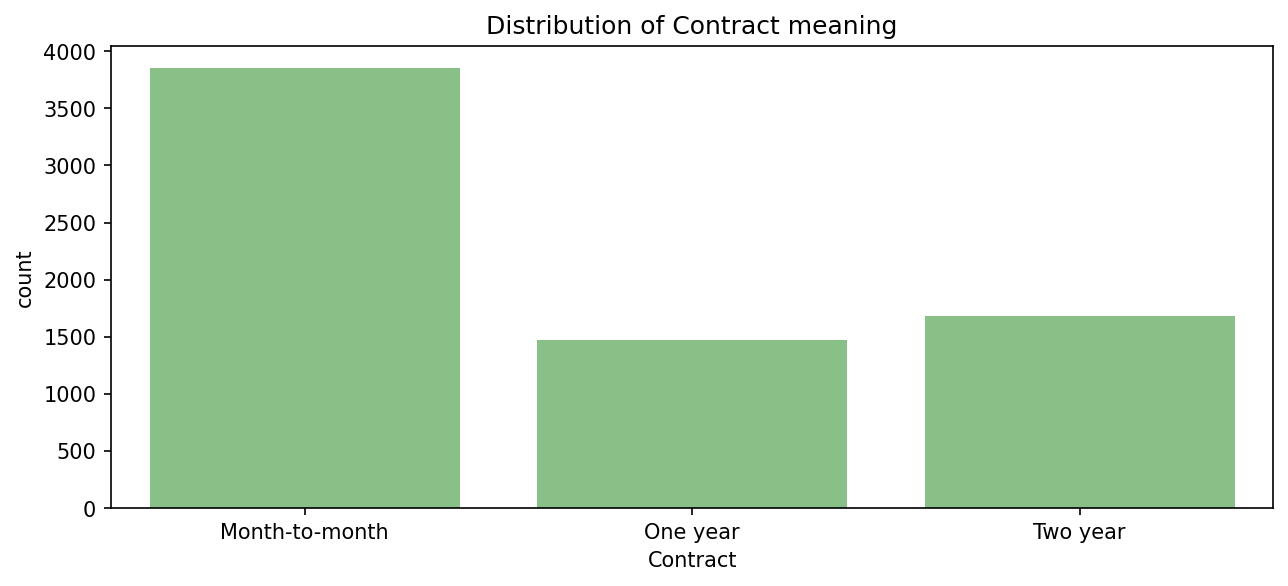

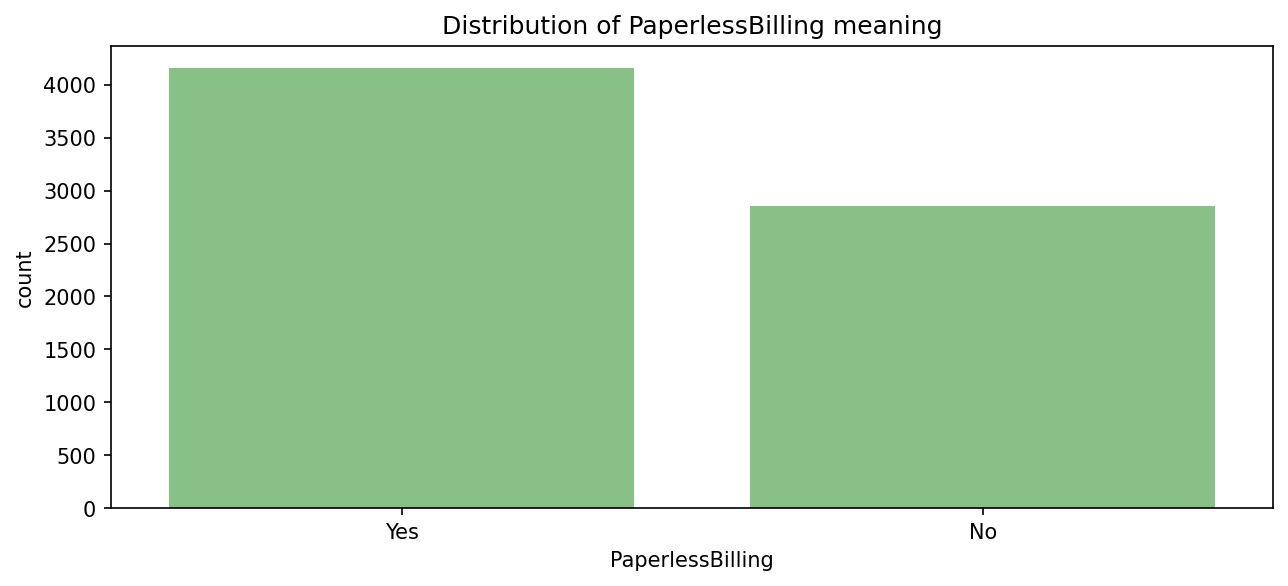

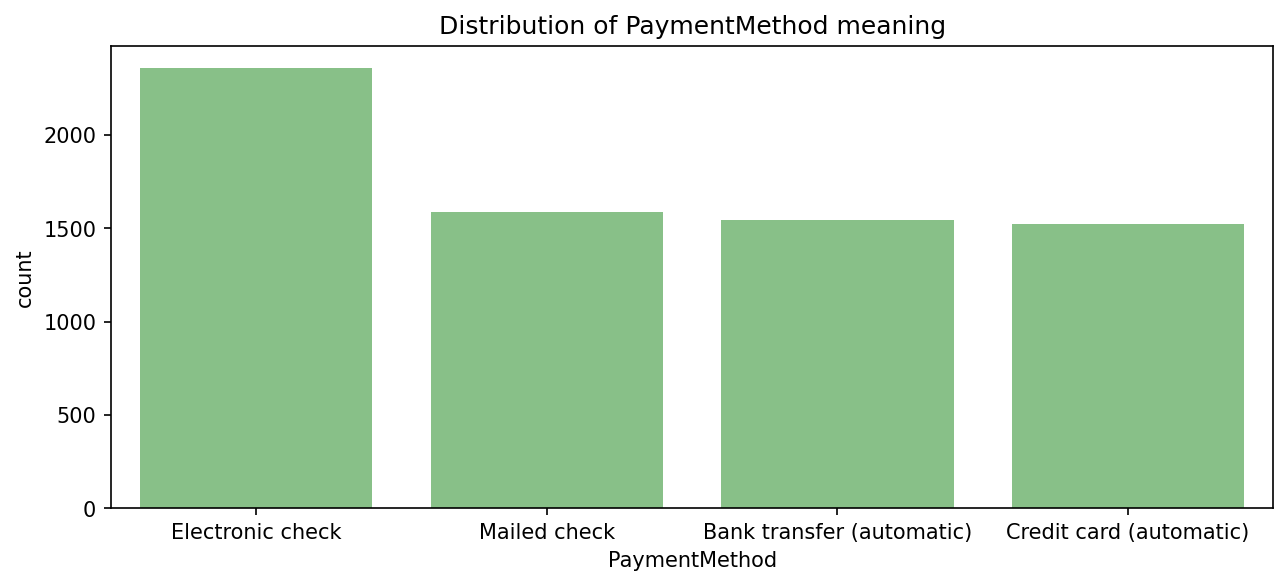

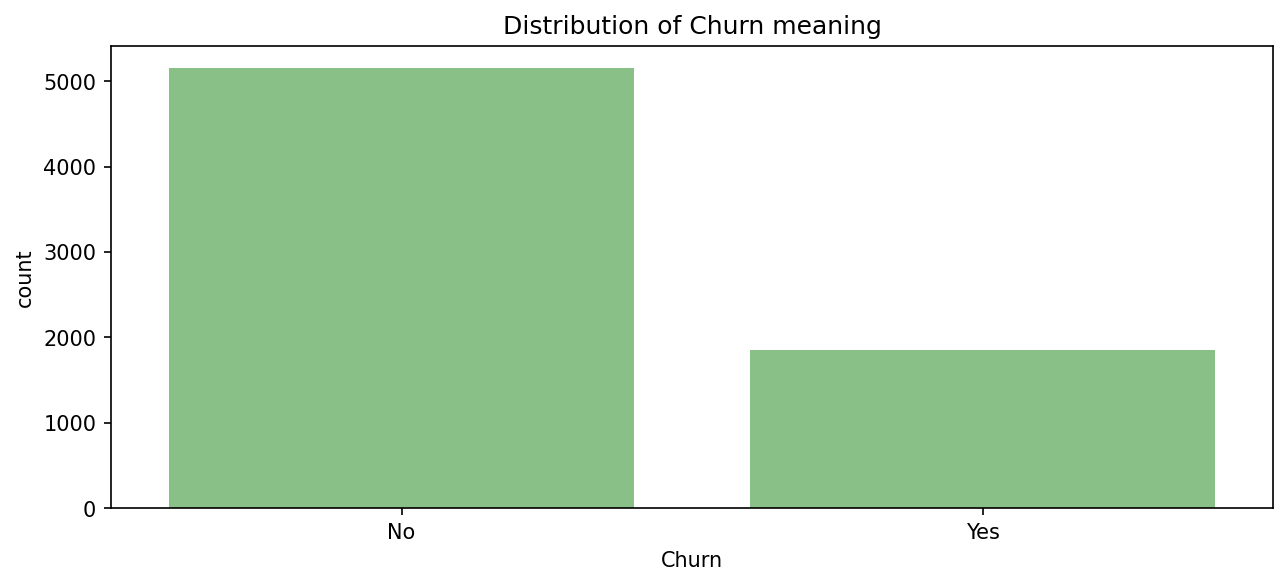

In [22]:
count_plot_cat(df_eda)

In [23]:
df_eda.phik_matrix(njobs=1)

interval columns not set, guessing: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.0,1.000000,0.015869,0.325010,0.026570,0.087578,0.160167,0.126773,0.109363,0.109544,0.134787,0.111102,0.113104,0.086488,0.241199,0.290879,0.303454,0.147089,0.234009
Partner,0.0,0.015869,1.000000,0.650423,0.489453,0.085011,0.000000,0.090752,0.091521,0.099232,0.075826,0.081301,0.077146,0.178158,0.013096,0.240912,0.202653,0.421728,0.230199
Dependents,0.0,0.325010,0.650423,1.000000,0.211049,0.012746,0.108568,0.117260,0.098040,0.094922,0.109850,0.088686,0.085468,0.145314,0.171956,0.223743,0.184921,0.115471,0.251102
tenure,0.0,0.026570,0.489453,0.211049,1.000000,0.372748,0.000000,0.365375,0.401364,0.402057,0.364649,0.321768,0.328359,0.666351,0.000000,0.371518,0.408532,0.841887,0.472806
MultipleLines,0.0,0.087578,0.085011,0.012746,0.372748,1.000000,0.739438,0.538264,0.561015,0.562815,0.538978,0.584593,0.585221,0.241010,0.099870,0.173175,0.710161,0.492756,0.023091
InternetService,0.0,0.160167,0.000000,0.108568,0.000000,0.739438,1.000000,0.949451,0.942837,0.942811,0.948867,0.946785,0.946308,0.507303,0.230260,0.320918,0.918937,0.507763,0.196140
OnlineSecurity,0.0,0.126773,0.090752,0.117260,0.365375,0.538264,0.949451,1.000000,0.947175,0.946739,0.952596,0.943065,0.943238,0.637972,0.207162,0.312450,0.812364,0.529035,0.211509
OnlineBackup,0.0,0.109363,0.091521,0.098040,0.401364,0.561015,0.942837,0.947175,1.000000,0.947435,0.947706,0.945742,0.945368,0.583055,0.194126,0.289980,0.818615,0.567738,0.177018
DeviceProtection,0.0,0.109544,0.099232,0.094922,0.402057,0.562815,0.942811,0.946739,0.947435,1.000000,0.950193,0.952753,0.953690,0.632702,0.194439,0.294565,0.827175,0.574353,0.170375


gender корриляция с target 0 => удаляем 'gender'

In [24]:
df_eda = df_eda.drop('gender', axis=1)

In [25]:
def create_heatmap(df):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    sns.heatmap(
        df,
        annot=True,
        fmt='.2f',
        cbar=False,
        ax=ax
    )
    
    ax.set_title('Correlation with target')
    
    plt.show()
    plt.close()

C:\Users\toperok\AppData\Local\Temp\ipykernel_21716\2635845679.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  df_eda1 = df_eda.copy().select_dtypes(include='object').astype('category')


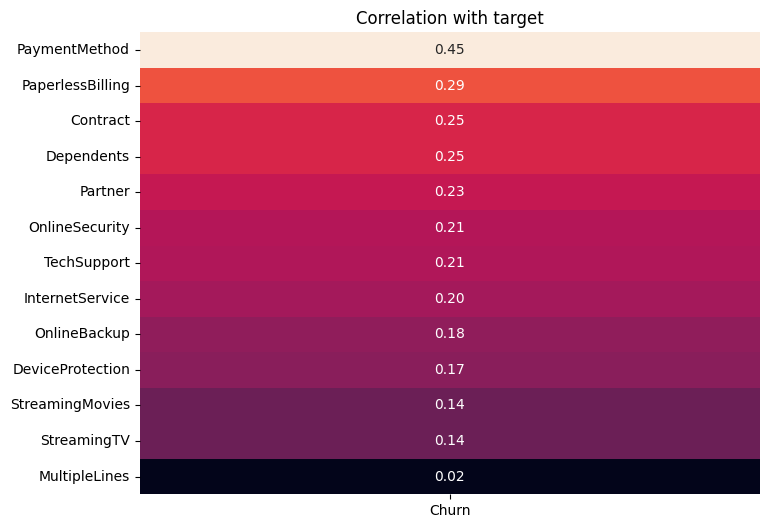

In [26]:
df_eda1 = df_eda.copy().select_dtypes(include='object').astype('category')

corr_mat = df_eda1.phik_matrix(njobs=6)
target_correlation = corr_mat[corr_mat.index != 'Churn'][['Churn']].sort_values(by='Churn', ascending=False)


create_heatmap(target_correlation)

In [27]:
df_eda = df_eda.drop('MultipleLines', axis=1)

C:\Users\toperok\AppData\Local\Temp\ipykernel_21716\2635845679.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  df_eda1 = df_eda.copy().select_dtypes(include='object').astype('category')


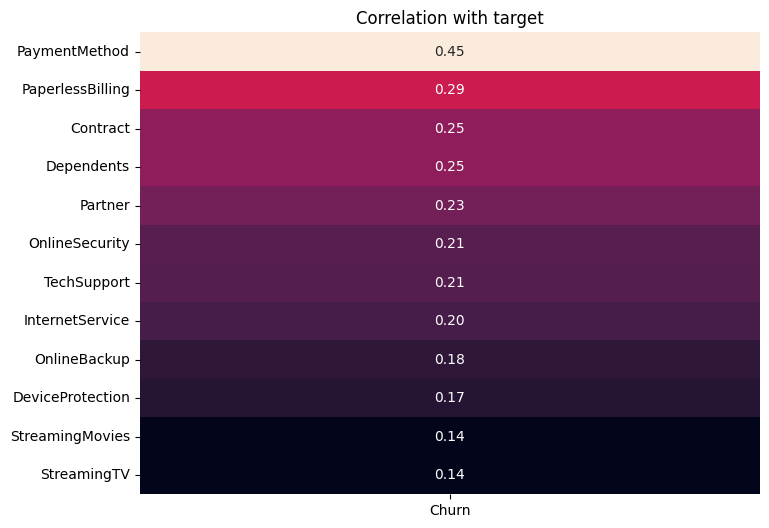

In [28]:
df_eda1 = df_eda.copy().select_dtypes(include='object').astype('category')

corr_mat = df_eda1.phik_matrix(njobs=6)
target_correlation = corr_mat[corr_mat.index != 'Churn'][['Churn']].sort_values(by='Churn', ascending=False)


create_heatmap(target_correlation)

In [29]:
def split_set(df):
    
    X = df.drop('Churn', axis=1)
    y = df['Churn']
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
                                                        X, 
                                                        y, 
                                                        test_size=0.15,
                                                        random_state=SEED
                                                       )
    
    return X_train_val, X_test, y_train_val, y_test

In [30]:
X_train_val, X_test, y_train_val, y_test = split_set(df_eda)

In [31]:
def bool_to_int(df):
    return df.astype(int)

In [32]:
def get_fall_feature_names(transformer, input_features):
    return input_features 

In [33]:
target = ['Churn']

num_cols_index = df_eda.select_dtypes(include=['number']).columns
cat_cols_index = df_eda.select_dtypes(include=['str']).columns
bool_cols_index = df_eda.select_dtypes(include=['bool']).columns

num_cols = [col for col in num_cols_index if col not in target]
cat_cols = [col for col in cat_cols_index if col not in target]
bool_cols = [col for col in bool_cols_index if col not in target]

In [34]:
le = LabelEncoder()
y_train_val_encoded = le.fit_transform(y_train_val)

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(
            StandardScaler()
        ), num_cols),
        
        ('cat',
        OneHotEncoder(drop='first', sparse_output=False),
        cat_cols),
        
        ('bool', make_pipeline(
           FunctionTransformer(bool_to_int, feature_names_out="one-to-one")
        ), bool_cols)
    ],
    remainder='drop'
).set_output(transform='pandas')

In [36]:
X_transform = preprocessor.fit_transform(X_train_val)
X_transform

,num__SeniorCitizen,num__tenure,num__MonthlyCharges,num__TotalCharges,cat__Partner_Yes,cat__Dependents_Yes,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,cat__OnlineBackup_No internet service,cat__OnlineBackup_Yes,cat__DeviceProtection_No internet service,cat__DeviceProtection_Yes,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__StreamingTV_No internet service,cat__StreamingTV_Yes,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check
3162,-0.445321,1.287465,0.309502,1.087627,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2675,-0.445321,1.573073,0.678603,1.646916,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
294,-0.445321,-0.834200,-1.507740,-0.910820,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2033,-0.445321,-0.262982,0.856503,0.031984,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6392,-0.445321,-1.201411,-0.330606,-0.939746,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,-0.445321,-0.670995,0.316153,-0.492503,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5707,-0.445321,-1.242212,-0.323955,-0.959998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1363,-0.445321,0.879452,0.643688,0.966334,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1550,-0.445321,0.838651,1.365265,1.532382,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [37]:
#To solve problem with f1_score => NaN
custom_f1 = make_scorer(f1_score, average='macro', zero_division=0)

# Func for all models metrics.
def show_metrics(name, pipeline):
    scoring = {
        "accuracy": "accuracy",
        "f1_score": custom_f1,
        "ROC-AUC": "roc_auc",
        "Logloss": "neg_log_loss"
    }

    cv_results = cross_validate(
        pipeline,
        X_train_val,
        y_train_val_encoded,
        cv=cv,
        scoring=scoring,
        n_jobs=4  
    )

    cv_row = {
        "model:": name,
        "accuracy:": cv_results["test_accuracy"].mean(),
        "f1 score:": cv_results["test_f1_score"].mean(),
        "ROC-AUC:": cv_results["test_ROC-AUC"].mean(),
        "Log loss:": -cv_results["test_Logloss"].mean()
    }

    metrics_df = pd.DataFrame([cv_row]).round(3)

    return metrics_df

In [38]:
# Logistic Regression Baseline

log_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=SEED)),
    ])


display(show_metrics(name='Log reg baseline', pipeline=log_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,Log reg baseline,0.798,0.726,0.839,0.424


In [39]:
log_filtered_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('var_thresh', VarianceThreshold(threshold=0.01)),
        ('rfe', RFE(estimator=LogisticRegression(), n_features_to_select=10)),
        ('model', LogisticRegression(random_state=SEED)),
])

display(show_metrics(name='Log reg(filter)', pipeline=log_filtered_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,Log reg(filter),0.789,0.713,0.834,0.43


In [40]:
# Log reg balanced

def objective_log(trial):
    n_features = trial.suggest_int("rfe_n_features", 5, 20)

    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", None])
    
    if penalty in ["l1", "elasticnet"]:
        solver = "saga"
    else:
        solver = trial.suggest_categorical("solver_l2_none", ["saga", "lbfgs"])
    
    params = {
        "penalty": penalty,
        "solver": solver,
        "C": trial.suggest_float("C", 1e-5, 1e2, log=True) if penalty is not None else 1.0,
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "max_iter": 3000,
        "random_state": SEED,
    }

    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0, 1)
    
    rfe_selector = RFE(
        LogisticRegression(class_weight="balanced", random_state=SEED),
        n_features_to_select=n_features,
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rfe", rfe_selector),
        ("model", LogisticRegression(**params)),
    ])

    # Cross-validation

    scoring = {
        "roc_auc": "roc_auc",
        "f1_macro": custom_f1,
    }

    cv_results = cross_validate(
        pipeline, 
        X_train_val, 
        y_train_val_encoded,
        cv=cv,
        scoring=scoring,
        n_jobs=4,
    )

    mean_roc_auc = cv_results["test_roc_auc"].mean()
    mean_f1 = cv_results["test_f1_macro"].mean()

    return mean_roc_auc, mean_f1

study_lr= optuna.create_study(
    directions=["maximize", "maximize"],
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

study_lr.optimize(objective_log, n_trials=100, n_jobs=4)

[I 2026-02-23 01:12:36,188] A new study created in memory with name: no-name-891c74e0-5b1c-4b38-8779-33b1040369f4


[I 2026-02-23 01:12:38,009] Trial 2 finished with values: [0.8395985035825368, 0.7113195401794485] and parameters: {'rfe_n_features': 17, 'penalty': None, 'solver_l2_none': 'lbfgs', 'class_weight': 'balanced'}.
[I 2026-02-23 01:12:38,178] Trial 0 finished with values: [0.8316847234409327, 0.7042202437564782] and parameters: {'rfe_n_features': 9, 'penalty': None, 'solver_l2_none': 'saga', 'class_weight': 'balanced'}.
[I 2026-02-23 01:12:38,734] Trial 1 finished with values: [0.8310627220457963, 0.7056854587349953] and parameters: {'rfe_n_features': 20, 'penalty': 'l2', 'solver_l2_none': 'saga', 'C': 0.002944579719501036, 'class_weight': 'balanced'}.
[I 2026-02-23 01:12:39,123] Trial 3 finished with values: [0.834638728304913, 0.7072928265129617] and parameters: {'rfe_n_features': 12, 'penalty': 'elasticnet', 'C': 0.5541423502033155, 'class_weight': 'balanced', 'l1_ratio': 0.6671118096445899}.
[I 2026-02-23 01:12:39,574] Trial 4 finished with values: [0.8388809257301159, 0.70969100525818

In [41]:
def find_best_balanced_trial(study):
    trials = study.best_trials

    best_trial = None
    min_distance = float('inf')

    for trial in trials:
        roc_auc, f1 = trial.values
        distance = np.sqrt((1-roc_auc)**2 + (1-f1)**2)

        if distance < min_distance:
            min_distance = distance
            best_trial = trial
    return best_trial


In [42]:
best_balanced_lr_trial = find_best_balanced_trial(study_lr)
best_lr_params = best_balanced_lr_trial.params.copy()

if 'solver_l2_none' in best_lr_params:
    best_lr_params['solver'] = best_lr_params.pop('solver_l2_none')
elif best_lr_params['penalty'] in ['l1', 'elasticnet']:
    best_lr_params['solver'] = 'saga'

rfe_ls_n_features = best_lr_params.pop("rfe_n_features")

final_rfe_model_lr = RFE(
    estimator=LogisticRegression(random_state=SEED),
    n_features_to_select = rfe_ls_n_features,
)

final_log_reg_model = LogisticRegression(
    **best_lr_params, 
    max_iter=3000, 
    random_state=SEED,
)

final_log_reg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("rfe", final_rfe_model_lr),
    ("model", final_log_reg_model),
])

final_lr_metrics = show_metrics(name="Best balanced LogReg model", pipeline=final_log_reg_pipe)

print("Параметры лучшей модели:", best_lr_params)
display(final_lr_metrics) 

Параметры лучшей модели: {'penalty': None, 'class_weight': None, 'solver': 'lbfgs'}


,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,Best balanced LogReg model,0.796,0.725,0.84,0.424


In [43]:
# KNN baseline

knn_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", KNeighborsClassifier())
])

display(show_metrics(name="KNN Baseline", pipeline=knn_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,KNN Baseline,0.757,0.683,0.771,1.738


In [44]:
%%time

# KNN filtered

rf_estimator = RFE(
    estimator=RandomForestClassifier(
        n_estimators=100,
        random_state=SEED,
        n_jobs=4,
    ),
    n_features_to_select=10,
    step=1
)

# SelectKBest хорошая методика для отбора, однако, для больших данных, поскольку может отсеить нужные признаки.
knn_filtered_pipeline = Pipeline([ 
    ("preprocessor", preprocessor),
    ("rfe", rf_estimator),
    ("model", KNeighborsClassifier(n_neighbors=20, weights="distance", p=1)),
])

display(show_metrics(name="KNN filtered", pipeline=knn_filtered_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,KNN filtered,0.775,0.693,0.802,0.836


CPU times: total: 172 ms
Wall time: 20.1 s


In [45]:
# Optuna KNN model

def objective_knn(trial):
    n_fearures = trial.suggest_int("rfe_n_features", 5, 20)

    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 51),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),
        "leaf_size": trial.suggest_int("leaf_size", 10, 100)
    }

    rfe_selector = RFE(
        estimator=LogisticRegression(class_weight="balanced", random_state=SEED),
        n_features_to_select=n_fearures,
    )

    pipeline = Pipeline(steps = [
        ("preprocessor", preprocessor),
        ("feature_selection", rfe_selector),
        ("model", KNeighborsClassifier(**params)),
    ])

    scoring = {
        "roc_auc": "roc_auc",
        "f1_macro": custom_f1,
    }

    cv_results = cross_validate(
        pipeline,
        X_train_val,
        y_train_val_encoded,
        cv=cv,
        scoring=scoring,
        n_jobs=4,
    )

    return cv_results["test_roc_auc"].mean(), cv_results["test_f1_macro"].mean()

study_knn = optuna.create_study(
    directions=["maximize", "maximize"],
    sampler=optuna.samplers.TPESampler(seed=SEED),
)

study_knn.optimize(objective_knn, n_trials=100, n_jobs=4)

[I 2026-02-23 01:13:58,689] A new study created in memory with name: no-name-e971b39c-fbff-469b-851b-e0cbef9fbc99
[I 2026-02-23 01:14:00,639] Trial 0 finished with values: [0.8224436021151702, 0.7125948979876284] and parameters: {'rfe_n_features': 20, 'n_neighbors': 47, 'weights': 'distance', 'p': 2, 'leaf_size': 24}.
[I 2026-02-23 01:14:01,281] Trial 1 finished with values: [0.8054478163459203, 0.7000183273806345] and parameters: {'rfe_n_features': 5, 'n_neighbors': 37, 'weights': 'distance', 'p': 1, 'leaf_size': 82}.
[I 2026-02-23 01:14:01,888] Trial 3 finished with values: [0.785739792074182, 0.6827804426900851] and parameters: {'rfe_n_features': 8, 'n_neighbors': 20, 'weights': 'distance', 'p': 2, 'leaf_size': 40}.
[I 2026-02-23 01:14:01,969] Trial 2 finished with values: [0.787615067155004, 0.693725611058483] and parameters: {'rfe_n_features': 6, 'n_neighbors': 35, 'weights': 'distance', 'p': 2, 'leaf_size': 65}.
[I 2026-02-23 01:14:02,996] Trial 4 finished with values: [0.8048158

In [46]:
best_balanced_knn_trail = find_best_balanced_trial(study_knn)
best_knn_params = best_balanced_knn_trail.params.copy()

rfe_knn_n_features = best_knn_params.pop("rfe_n_features") 

final_rfe_model_knn = RFE(
    estimator=LogisticRegression(class_weight="balanced", random_state=SEED),
    n_features_to_select = rfe_knn_n_features,
)
final_knn_model = KNeighborsClassifier(**best_knn_params)

final_knn_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rfe", final_rfe_model_knn),
    ("model", final_knn_model),
])

final_knn_metrics = show_metrics(name="Best balanced KNN model", pipeline=final_knn_pipe)
print("Параметры лучшей модели:", best_knn_params)
display(final_knn_metrics) 

Параметры лучшей модели: {'n_neighbors': 45, 'weights': 'uniform', 'p': 1, 'leaf_size': 33}


,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,Best balanced KNN model,0.794,0.726,0.836,0.485


При использовании TPESampler KNN выдает результаты немного хуже.

In [47]:
# SVC baseline

svc_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", SVC(max_iter=3000, random_state=SEED, probability=True))
])

display(show_metrics(name= "SVC baseline", pipeline=svc_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,SVC baseline,0.792,0.702,0.787,0.47


In [48]:
# SVC filtered 

rfe_svc_estimator = RFE(estimator=LogisticRegression(max_iter=3000, random_state=SEED), n_features_to_select=7)

svc_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rfe", rfe_svc_estimator),
    ("model", SVC(max_iter=3000, random_state=SEED, probability=True))
])

display(show_metrics(name= "SVC baseline", pipeline=svc_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,SVC baseline,0.786,0.69,0.732,0.497


In [49]:
# SVC balanced

def objective_svc(trial):

    kernel=  trial.suggest_categorical("kernel", ["poly", "rbf", "sigmoid"])

    n_features = trial.suggest_int("rfe_n_features", 5, 20)

    params = {
        "kernel": kernel,
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "class_weight": trial.suggest_categorical("class_weight", ['balanced', None]),
        "probability": True,
        "random_state": SEED,
        "max_iter": 10000,
    }

    if kernel == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 3)
        params["coef0"] = trial.suggest_float("coef0", 0.0, 10.0)
    if kernel == "sigmoid":
        params["coef0"] = trial.suggest_float("coef0", 0.0, 10.0)
    
    rfe_selector = RFE(
        estimator=LogisticRegression(class_weight="balanced", random_state=SEED),
        n_features_to_select=n_features,
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("rfe", rfe_selector),
        ("model", SVC(**params)),
    ])
    
    scoring = {
        "roc_auc": "roc_auc",
        "f1_macro": custom_f1,
    }

    cv_results = cross_validate(
        pipeline,
        X_train_val,
        y_train_val_encoded,
        cv=cv,
        scoring=scoring,
        n_jobs=4
    )

    return cv_results["test_roc_auc"].mean(), cv_results["test_f1_macro"].mean()

study_svc = optuna.create_study(
    directions=["maximize", "maximize"],
    sampler=optuna.samplers.TPESampler(seed=SEED),
)

study_svc.optimize(objective_svc, n_trials=100, n_jobs=4)

[I 2026-02-23 01:15:19,402] A new study created in memory with name: no-name-a1df8f61-e6d1-4f17-8897-528d023688bb
[I 2026-02-23 01:15:29,381] Trial 0 finished with values: [0.7651749991154979, 0.3380203464992292] and parameters: {'kernel': 'sigmoid', 'rfe_n_features': 5, 'C': 1.9805290037913397, 'gamma': 'scale', 'class_weight': 'balanced', 'coef0': 5.988861845367696}.
[I 2026-02-23 01:15:34,916] Trial 3 finished with values: [0.6999473726290453, 0.4232332866858689] and parameters: {'kernel': 'sigmoid', 'rfe_n_features': 12, 'C': 0.18424837980476852, 'gamma': 'scale', 'class_weight': None, 'coef0': 6.305004509150573}.
[I 2026-02-23 01:15:41,084] Trial 1 finished with values: [0.7078368873573992, 0.6082124986007122] and parameters: {'kernel': 'poly', 'rfe_n_features': 16, 'C': 70.84269068981132, 'gamma': 'scale', 'class_weight': 'balanced', 'degree': 2, 'coef0': 1.6979959868633565}.
[I 2026-02-23 01:15:42,732] Trial 2 finished with values: [0.8009440290584466, 0.713002973167109] and par

In [50]:
best_balanced_svc_trail = find_best_balanced_trial(study_svc)
best_svc_params = best_balanced_svc_trail.params.copy()

rfe_svc_n_features = best_svc_params.pop("rfe_n_features") 

final_rfe_model_svc = RFE(
    estimator=LogisticRegression(class_weight="balanced", random_state=SEED),
    n_features_to_select = rfe_svc_n_features,
)
final_svc_model = SVC(**best_svc_params, probability=True, random_state=SEED)

final_svc_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rfe", final_rfe_model_svc),
    ("model", final_svc_model),
])

final_svc_metrics = show_metrics(name="Best balanced KNN model", pipeline=final_svc_pipe)
print("Параметры лучшей модели:", best_svc_params)
display(final_svc_metrics) 

Параметры лучшей модели: {'kernel': 'poly', 'C': 0.004324981866147184, 'gamma': 'scale', 'class_weight': None, 'degree': 2, 'coef0': 5.095492957481682}


,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,Best balanced KNN model,0.794,0.709,0.828,0.439


In [51]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_cols)
    ],
).set_output(transform="pandas")

In [52]:
X_transformed = tree_preprocessor.fit_transform(X_train_val)
X_transformed.head()



,cat__Partner_Yes,cat__Dependents_Yes,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,cat__OnlineBackup_No internet service,cat__OnlineBackup_Yes,cat__DeviceProtection_No internet service,cat__DeviceProtection_Yes,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__StreamingTV_No internet service,cat__StreamingTV_Yes,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check
3162,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2675,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
294,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2033,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6392,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [53]:
# Tree baseline

tree_pipeline = Pipeline(steps=[
    ("preprocessor", tree_preprocessor),
    ("model", DecisionTreeClassifier(random_state=SEED))
])

display(show_metrics(name="DecisionTreeClassifier baseline", pipeline=tree_pipeline))

,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,DecisionTreeClassifier baseline,0.733,0.653,0.703,5.224


In [54]:
# DT balanced

def objective_dt(trial):
    n_features = trial.suggest_int("rfe_n_features", 5, 20)

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05), 
        # "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 100), We dont really need this, bc we have max_depth
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state": SEED
    }

    rfe_selector = RFE(
        estimator=LogisticRegression(class_weight="balanced", random_state=SEED),
        n_features_to_select=n_features,
    )

    pipeline = Pipeline(steps=[
        ("preprocessor", tree_preprocessor),
        ("rfe", rfe_selector),
        ("model", DecisionTreeClassifier(**params)),
    ])

    scoring = {
        "roc_auc": "roc_auc",
        "f1_macro": custom_f1,
    }

    cv_results = cross_validate(
        pipeline,
        X_train_val,
        y_train_val_encoded,
        cv=cv,
        scoring=scoring,
        n_jobs=4,
    )

    return cv_results["test_roc_auc"].mean(), cv_results["test_f1_macro"].mean()

study_dt = optuna.create_study(
    directions=["maximize", "maximize"],
    sampler=optuna.samplers.TPESampler(seed=SEED),
)
study_dt.optimize(objective_dt, n_trials=100, n_jobs=4)

[I 2026-02-23 01:23:07,467] A new study created in memory with name: no-name-cbfeadce-6d8f-48d1-9145-5b28585164e6
[I 2026-02-23 01:23:07,936] Trial 0 finished with values: [0.5, 0.4232332866858689] and parameters: {'rfe_n_features': 15, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 6, 'ccp_alpha': 0.047106485518630364, 'max_features': 'sqrt', 'criterion': 'gini', 'class_weight': None}.
[I 2026-02-23 01:23:08,212] Trial 1 finished with values: [0.7145704752003527, 0.4232332866858689] and parameters: {'rfe_n_features': 19, 'max_depth': 14, 'min_samples_leaf': 20, 'min_samples_split': 6, 'ccp_alpha': 0.024096896832684258, 'max_features': 'log2', 'criterion': 'log_loss', 'class_weight': None}.
[I 2026-02-23 01:23:08,248] Trial 3 finished with values: [0.7161784153232628, 0.4232332866858689] and parameters: {'rfe_n_features': 17, 'max_depth': 9, 'min_samples_leaf': 16, 'min_samples_split': 4, 'ccp_alpha': 0.04994514419227084, 'max_features': None, 'criterion': 'log_loss', 'cla

In [55]:
best_balanced_dt_trial = find_best_balanced_trial(study_dt)
best_dt_params = best_balanced_dt_trial.params.copy()

rfe_dt_n_features = best_dt_params.pop("rfe_n_features")

final_rfe_model_dt = RFE(
    estimator=LogisticRegression(class_weight="balanced", random_state=SEED),
    n_features_to_select=rfe_dt_n_features,
)

final_dt_model = DecisionTreeClassifier(**best_dt_params, random_state=SEED)

final_dt_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rfe", final_rfe_model_dt),
    ("model", final_dt_model),
])

final_dt_metrics = show_metrics(name="Best balanced Decision Tree", pipeline=final_dt_pipe)
print("Параметры лучшей модели:", best_dt_params)
display(final_dt_metrics)

Параметры лучшей модели: {'max_depth': 3, 'min_samples_leaf': 19, 'min_samples_split': 10, 'ccp_alpha': 1.0930355853625354e-05, 'max_features': None, 'criterion': 'gini', 'class_weight': None}


,model:,accuracy:,f1 score:,ROC-AUC:,Log loss:
0,Best balanced Decision Tree,0.787,0.684,0.807,0.45


In [56]:
#